In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import time
import tqdm
from IPython import display
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage

In [343]:
def phi(x, y, a, b):
	return np.arctan(np.cos(np.pi * x / a))

def psi(x, y, a, b):
	return np.sin(2 * np.pi * x / a) * np.sin(np.pi * y / b)


def testphi(x, y, a, b):
	# аргумент синуса - kx, где k = \pm (2pi n)/a
	# аргумент косинуса - ky, где k != \pm (pi + 2pi*n) / b
	# n = 1 # количество периодов по x - должно быть 1 (и больше) или сдвигать фазу(брать косинус) т.к. у синуса 0 в 0
	# m = 1 # количество периодов по y - может быть меньше 1
	# nu = 2 * np.pi * n / a
	# mu = 2 * np.pi * m / b
	# # lambda = nu + mu
	# k = np.sqrt(nu ** 2 + mu ** 2)
	return np.zeros((x.shape[0], y.shape[1]))

def testpsi(x, y, a, b):
	n = 1 # количество периодов по x - должно быть 1 (и больше) или сдвигать фазу(брать косинус) т.к. у синуса 0 в 0
	m = 1 # количество периодов по y - может быть меньше 1
	nu = 2 * np.pi * n / a
	mu = 2 * np.pi * m / b
	# lambda = nu + mu
	k = np.sqrt(nu ** 2 + mu ** 2)
	# return np.sin(nu * x) * np.cos(mu * y) # тестовый пример 1
	return np.sin(nu * x) * np.cos(mu * y) + np.sin(2 * nu * x) * np.cos(2 * mu * y)
	

def testU(x, y, t, a, b):
	n = 1 # количество периодов по x - должно быть 1 (и больше) или сдвигать фазу(брать косинус) т.к. у синуса 0 в 0
	m = 1 # количество периодов по y - может быть меньше 1
	nu = 2 * np.pi * n / a
	mu = 2 * np.pi * m / b
	# lambda = nu + mu
	k = np.sqrt(nu ** 2 + mu ** 2)
	# return (1 / k) * np.sin(nu * x) * np.cos(mu * y) * np.sin(k * t) # тестовый пример 1
	return (1 / k) * np.sin(nu * x) * np.cos(mu * y) * np.sin(k * t) + (1 / (2*k)) * np.sin(2 * nu * x) * np.cos(2 * mu * y) * np.sin(2 * k * t) # тестовый пример 2

In [237]:
class Solver:
	u = None
	def __init__(self, a, b, step, ut0, dudt0):
		self.a = float(a)
		self.b = float(b)
		self.dx = step
		self.dy = step
		self.nodes_x = int(self.a / self.dx)
		self.nodes_y = int(self.b / self.dy)
		self.x = np.linspace(-self.a/2, self.a/2, self.nodes_x)
		self.y = np.linspace(-self.b/2, self.b/2, self.nodes_y)
		print(len(self.x))
		print(len(self.y))
		self.u0 = np.zeros((self.nodes_y, self.nodes_x))
		self.u1 = np.zeros((self.nodes_y, self.nodes_x))
		print(self.u0.shape)
		print(self.u1.shape)
		self.I = ut0
		self.V = dudt0
		self.invdxsq = 1 / (self.dx ** 2)
		self.invdysq = 1 / (self.dy ** 2)
	
	def uxx(self, i, j, first_step):
		u = self.u0 if first_step else self.u1
		if j in (0, self.nodes_x - 1): return 0
		else:
			return (u[i, j-1] - 2 * u[i, j] + u[i, j+1]) * self.invdxsq

	def uyy(self, i, j, first_step):
		u = self.u0 if first_step else self.u1
		if i == 0: return (2 * u[i+1, j] - 2 * u[i, j]) * self.invdysq
		elif i == self.nodes_y - 1: return (2 * u[i-1, j] - 2 * u[i, j]) * self.invdysq
		else:
			return (u[i-1, j] - 2 * u[i, j] + u[i+1, j]) * self.invdysq

	def first_step(self, dt):
		for i in range(self.nodes_y):
			for j in range(self.nodes_x):
				self.u0[i, j] = self.I(self.x[j], self.y[i], self.a, self.b)
		for i in range(self.nodes_y):
			for j in range(self.nodes_x):
				self.u1[i, j] = self.u0[i, j] + dt * self.V(self.x[j], self.y[i], self.a, self.b) + dt**2 * (self.uxx(i, j, True) + self.uyy(i, j, True)) / 2
	
	def advance(self, dt):
		if self.u is not None:
			self.u0 = self.u1
			self.u1 = self.u	
		self.u = 2*self.u1.copy() - self.u0.copy()
		# закрепление
		self.u[:,0] *= 0
		self.u[:, -1] *= 0
		# self.u[0,:] *= 0
		# self.u[-1, :] *= 0
		for i in range (self.u0.shape[0]):
			for j in range(1, self.u0.shape[1]-1):
				self.u[i, j] += dt**2 * (self.uxx(i, j, False) + self.uyy(i, j, False))
		# закрепление
		# self.u[:,0] *= 0
		# self.u[:, -1] *= 0
		# # self.u[0,:] *= 0
		# # self.u[-1, :] *= 0
		return self.u


In [337]:
class SolverVec:
	u = None
	def __init__(self, a, b, step, ut0, dudt0):
		self.a = np.float64(a)
		self.b = np.float64(b)
		self.dx = np.float64(step)
		self.dy = np.float64(step)
		self.nodes_x = int(self.a / self.dx)
		self.nodes_y = int(self.b / self.dy)
		x = np.linspace(-self.a/2, self.a/2, self.nodes_x, dtype='float64')
		y = np.linspace(-self.b/2, self.b/2, self.nodes_y, dtype='float64')
		self.x, self.y = np.meshgrid(x, y)
		print(self.x.shape)
		print(self.y.shape)
		self.I = ut0
		self.V = dudt0
		self.invdxsq = 1 / (self.dx ** 2)
		self.invdysq = 1 / (self.dy ** 2)
	
	def uxx(self, first_step):
		u = self.u0 if first_step else self.u1
		uxx = np.zeros((u.shape[0], u.shape[1]))
		uxx[:, 1:-1] = (u[:, :-2] - 2 * u[:, 1:-1] + u[:, 2:]) * self.invdxsq
		return uxx

	def uyy(self, first_step):
		u = self.u0 if first_step else self.u1
		uyy = np.zeros((u.shape[0], u.shape[1]))
		uyy[0, :] = (2 * u[1, :] - 2 * u[0, :]) * self.invdysq
		uyy[-1, :] = (2 * u[-2, :] - 2 * u[-1, :]) * self.invdysq
		uyy[1:-1, :] = (u[:-2, :] - 2 * u[1:-1, :] + u[2:, :]) * self.invdysq
		return uyy

	def first_step(self, dt):
		self.u0 = self.I(self.x, self.y, self.a, self.b)
		uxx = self.uxx(True)
		uyy = self.uyy(True)
		psi = self.V(self.x, self.y, self.a, self.b)
		self.u1 = self.u0 + dt * psi + 0.5 * dt**2 * (uxx + uyy)

	def advance(self, dt):
		if self.u is not None:
			self.u0 = self.u1
			self.u1 = self.u
		uxx = self.uxx(False)
		uyy = self.uyy(False)
		self.u = 2 * self.u1.copy() - self.u0.copy() + dt**2 * (uxx + uyy)
		return self.u


In [338]:
a = 2
b = 1
h = 0.01
dt = round(h*h/np.sqrt(h**2 + h**2), 7) - (1 * 1e-4)

print(dt)
print(h*h/np.sqrt(h**2 + h**2))

0.0069711
0.007071067811865475


In [276]:
n = 1 # количество периодов по x - должно быть 1 (и больше) или сдвигать фазу(брать косинус) т.к. у синуса 0 в 0
m = 1 # количество периодов по y - может быть меньше 1
nu = 2 * np.pi * n / a
mu = 2 * np.pi * m / b
# lambda = nu + mu
k = np.sqrt(nu ** 2 + mu ** 2)
print(f'{n}\t{m}\t{k}\t{type(k)}')

1	1	7.024814731040727	<class 'numpy.float64'>


In [239]:
solver = Solver(a, b, h, testphi, testpsi)
solver.first_step(dt)

200
100
(100, 200)
(100, 200)


In [341]:
solverVec = SolverVec(a, b, h, testphi, testpsi)
solverVec.first_step(dt)

(100, 200)
(100, 200)


In [333]:
# определяем погрешность
errList = []
maxU = []
maxSolv = []
observations = 100000
t = 2 * dt
for i in tqdm.trange(2, observations + 2):
	u = solverVec.advance(dt)
	uTrue = testU(solverVec.x, solverVec.y, t, a, b)
	err = np.max(np.abs(u - uTrue))
	errList.append(err)
	maxU.append(np.max(np.abs(uTrue)))
	maxSolv.append(np.max(np.abs(u)))
	t += dt

100%|██████████| 100000/100000 [01:42<00:00, 979.05it/s]


In [318]:
plt.rcParams['figure.dpi'] = 300

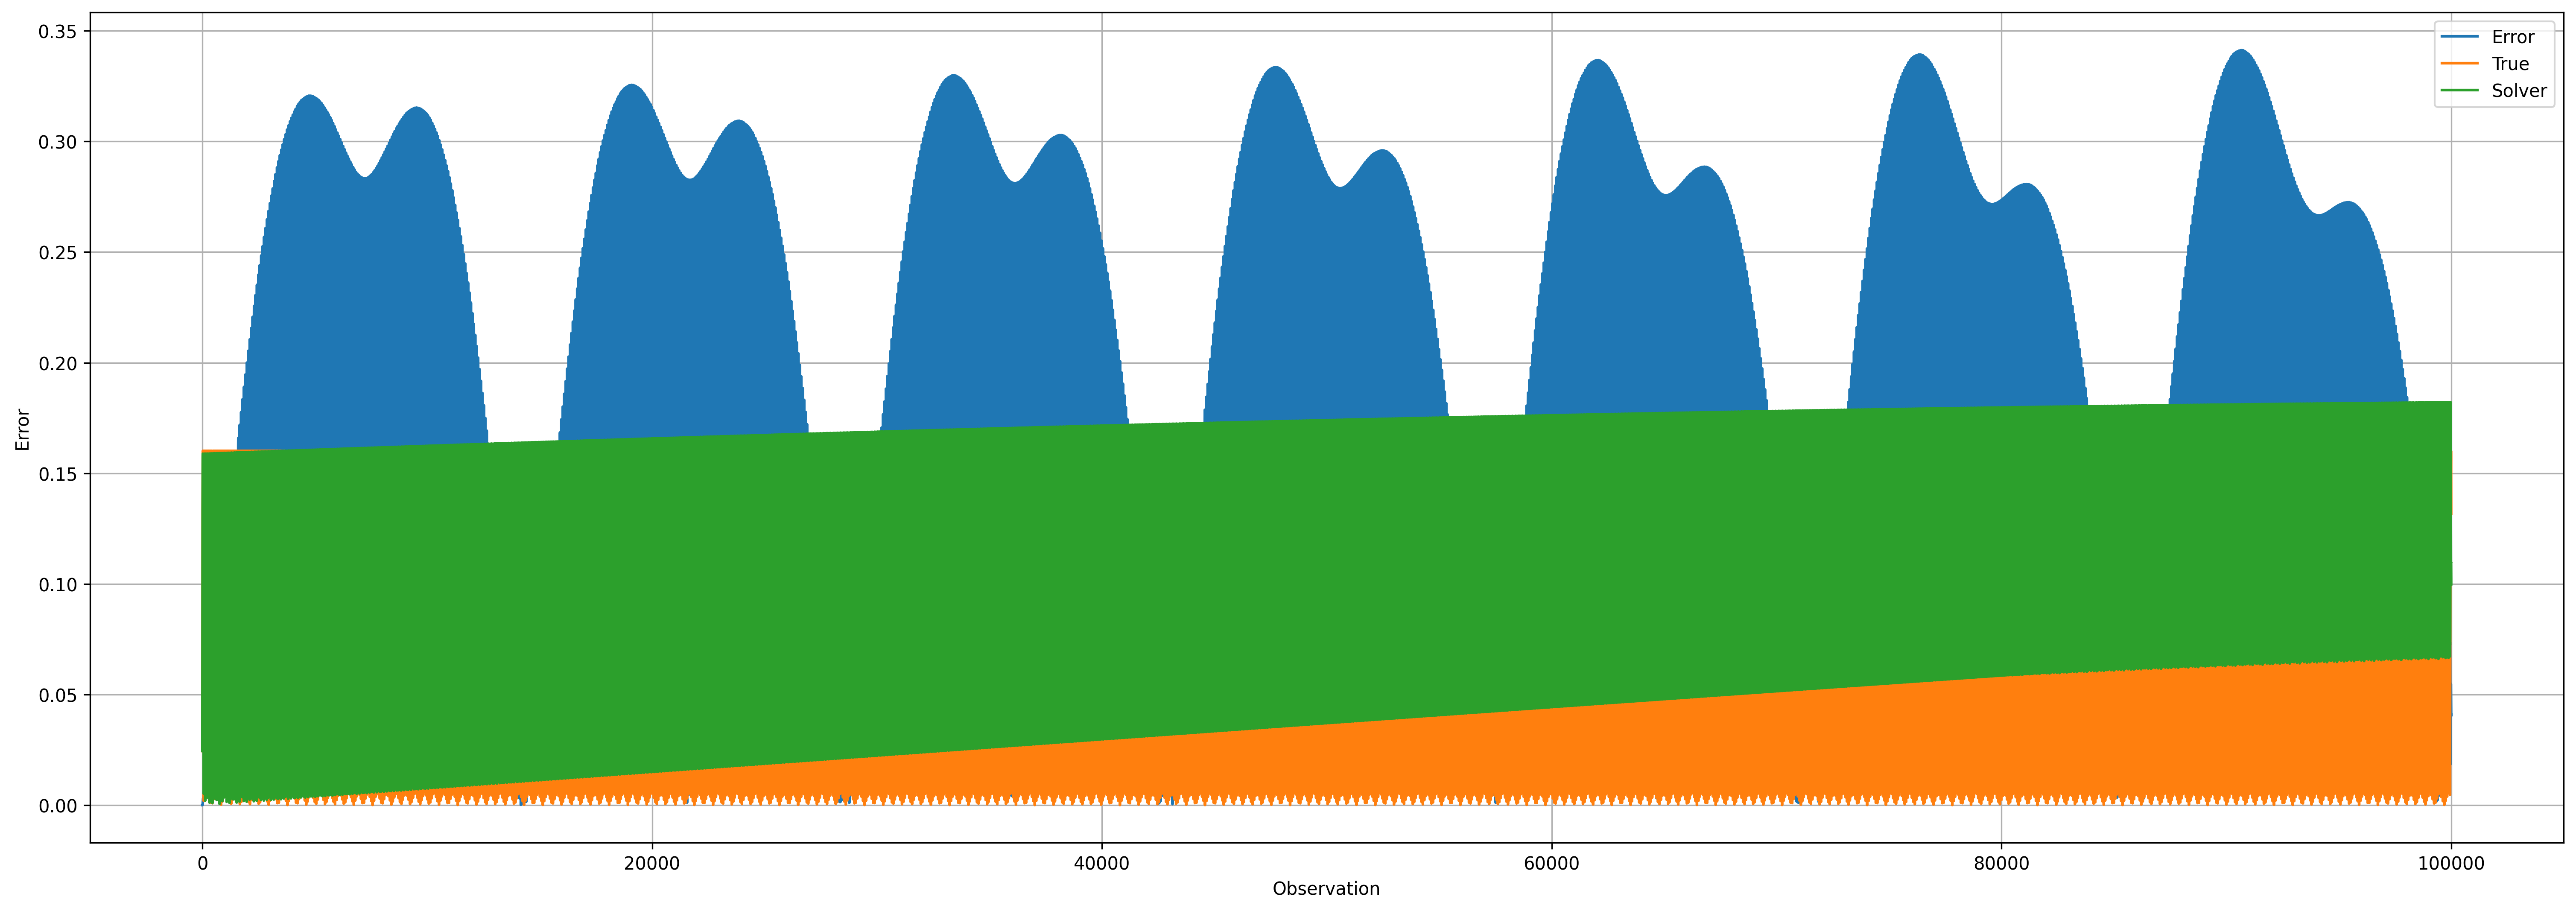

In [335]:
fig, axs = plt.subplots(nrows=1, ncols=1, constrained_layout=True, figsize=(20, 7))
axs.plot([i for i in range(observations)], [errList[i] for i in range(observations)], label='Error')
axs.plot([i for i in range(observations)], [maxU[i] for i in range(observations)], label='True')
axs.plot([i for i in range(observations)], [maxSolv[i] for i in range(observations)], label='Solver')
axs.set_xlabel('Observation')
axs.set_ylabel('Error')
#axs.set_ylim(0, 2)
axs.grid()
axs.legend()
plt.show()

In [ ]:
for i, el in enumerate(errList):
	print(f"{i}\t{el}")

In [39]:
errArray = np.array(errList)
zeroerrIdxs = np.argwhere(errArray < h)
print(zeroerrIdxs.shape)

(202, 1)


In [233]:
u = solver.advance(dt)
uv = solverVec.advance(dt)
print(np.array_equal(u, uv))

True


In [257]:
# сравнение времени выполнения скалярного и векторного кода
iterations = 60
start = time.time()
for i in tqdm.trange(iterations):
	u = solver.advance(dt)

print('[Scalar] Среднее время итерации:', (time.time() - start) / iterations)

start = time.time()
for i in tqdm.trange(iterations):
	u = solverVec.advance(dt)

print('[Vector] Среднее время итерации:', (time.time() - start) / iterations)

100%|██████████| 60/60 [08:39<00:00,  8.66s/it]


[Scalar] Среднее время итерации: 8.657296208540599


100%|██████████| 60/60 [00:06<00:00,  9.86it/s]

[Vector] Среднее время итерации: 0.10144221782684326


In [225]:
# сравнение скалярного и векторного метода (на равенство решений)
iterations = 500
for i in tqdm.trange(iterations):
	u = solver.advance(dt)
	uv = solverVec.advance(dt)
	if not np.array_equal(u, uv): 
		print(i)
		break

 84%|████████▍ | 420/500 [00:37<00:07, 11.32it/s]

420


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
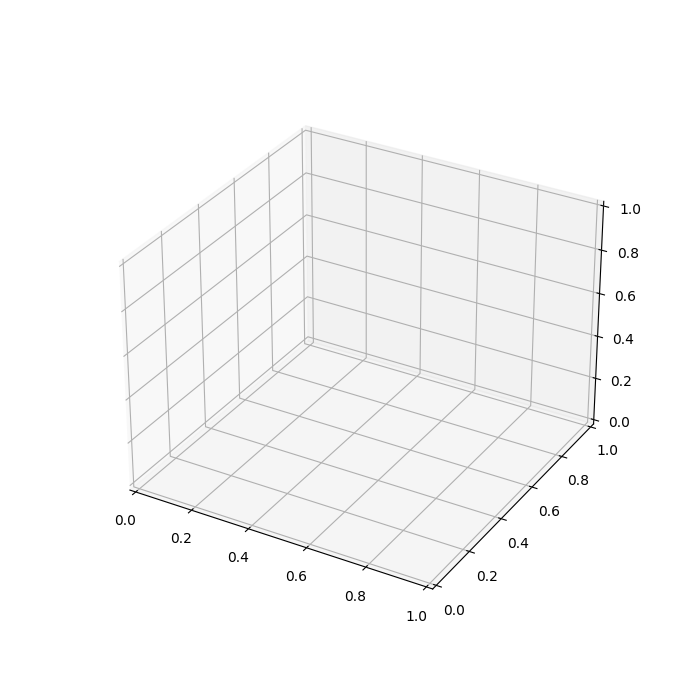

In [12]:
x1, y1 = np.meshgrid(solverVec.x, solverVec.y)
%matplotlib widget
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(projection='3d')
plt.show()

# display.clear_output()
for i in range(500):
	u = solverVec.advance(dt)
	# ax.clear()
	ax.cla()
	ax.set_xlim(-a/2, a/2)
	ax.set_ylim(-b/2, b/2)
	ax.set_zlim(-1, 1)
	ax.plot_surface(x1, y1, u, cmap='viridis', edgecolor='none')
	
	#plt.savefig(f'./render/1/render{i}.png')
	#del ax, u

In [ ]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
x1, y1 = np.meshgrid(solver.x, solver.y)

u = solver.advance(dt)
ax.clear()
ax.set_xlim(-a/2, a/2)
ax.set_ylim(-b/2, b/2)
ax.set_zlim(-1, 1)
ax.plot_surface(x1, y1, u, cmap='viridis', edgecolor='none')
plt.draw()

In [229]:
print(uv[u == uv]) # вывести неравные элементы для сравнения скалярного и векторного

[ 0.00000000e+000 -9.88984626e+303              inf ...              inf
 -8.58546157e+303  0.00000000e+000]


In [ ]:
# прогон и анимация решения задачи (решение уравнения)
solverVec = SolverVec(a, b, h, phi, psi)
solverVec.first_step(dt)

drop = 4
duration = drop * 10
fps = 30
iterations = fps * duration + 1
time_cube = np.zeros((iterations, solverVec.x.shape[0], solverVec.x.shape[1])) # len(solverVec.y), len(solverVec.x)

start = time.time()
for i in tqdm.trange(iterations):
	curU = solverVec.advance(dt)
	if i % drop == 0: time_cube[i//drop] = curU

print('Среднее время итерации:', (time.time() - start) / iterations)

x1, y1 = np.meshgrid(solverVec.x, solverVec.y)

# figsize - 1 == 72px -> 20 - 1440p / 15 - 1080p
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

# display.clear_output()
idx = 0

def make_frame(t):
	global idx
	ax.clear()
	ax.set_xlim(-a/2, a/2)
	ax.set_ylim(-b/2, b/2)
	ax.set_zlim(-1, 1) 
	#ax.plot_surface(x1, y1, time_cube[idx], cmap='viridis', edgecolor='none')
	ax.plot_surface(x1, y1, time_cube[idx], edgecolor='none')
	npimg = mplfig_to_npimage(fig)
	idx += 1
	return npimg

animation = VideoClip(make_frame, duration=duration/drop)
animation.write_videofile(f'vid_final{1}.mp4', fps=fps, codec='mpeg4', audio=False, bitrate='6M', threads = 12, preset='ultrafast')

In [ ]:
# прогон и анимация тестового примера (точное решения)
duration = 40
fps = 30
iterations = fps * duration + 1
print(iterations)
print(len(np.arange(0, duration, 1.0/fps)))

time_cube = np.zeros((iterations, solverVec.y.shape[0], solverVec.x.shape[0]))

x1, y1 = np.meshgrid(solverVec.x, solverVec.y)
start = time.time()
t = 0
for i in tqdm.trange(iterations):
	if i % 4 == 0: time_cube[i//4] = testU(x1, y1, t, a, b)
	t += dt

print('Среднее время итерации:', (time.time() - start) / iterations)

# figsize - 1 == 72px -> 20 - 1440p / 15 - 1080p

fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

# display.clear_output()
idx = 0

# каждая отрисовка ~ <=40мс
def make_frame(t):
	global idx
	ax.clear()
	ax.set_xlim(-a/2, a/2)
	ax.set_ylim(-b/2, b/2)
	ax.set_zlim(-1, 1)
	#ax.plot_surface(x1, y1, time_cube[idx], cmap='viridis', edgecolor='none')
	ax.plot_surface(x1, y1, time_cube[idx], edgecolor='none')
	npimg = mplfig_to_npimage(fig)
	idx += 1
	return npimg

animation = VideoClip(make_frame, duration=duration/4)
animation.write_videofile(f'vid_final{1}.mp4', fps=fps, codec='mpeg4', audio=False, bitrate='6M', threads = 12, preset='ultrafast')

In [ ]:
x1, y1 = np.meshgrid(solverVec.x, solverVec.y)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection='3d')
#ls = LightSource(270, 45)
display.clear_output()
def make_frame(t):
	ax.clear()
	uv = solverVec.advance(dt)
	ax.set_xlim(-a/2, a/2)
	ax.set_ylim(-b/2, b/2)
	ax.set_zlim(-1, 1)
	ax.plot_surface(x1, y1, uv, cmap='viridis', edgecolor='none')
	#rgb = ls.shade(u, cmap=cm.gist_earth, vert_exag=0.1, blend_mode='soft')
	#ax.plot_surface(x1, y1, u, facecolors=rgb, edgecolor='none', antialiased=False, shade=False)
	npimg = mplfig_to_npimage(fig)
	return npimg

In [ ]:
animation = VideoClip(make_frame, duration=10)
animation.write_videofile(f'vid{12}.mp4', fps=60, codec='mpeg4', audio=False, bitrate='3M')

(100, 200)
(100, 200)
1201
1200


100%|██████████| 1201/1201 [00:00<00:00, 2116.82it/s]


Среднее время итерации: 0.0004757423384997569
Moviepy - Building video vid_final1.mp4.
Moviepy - Writing video vid_final1.mp4



Moviepy - Done !
Moviepy - video ready vid_final1.mp4


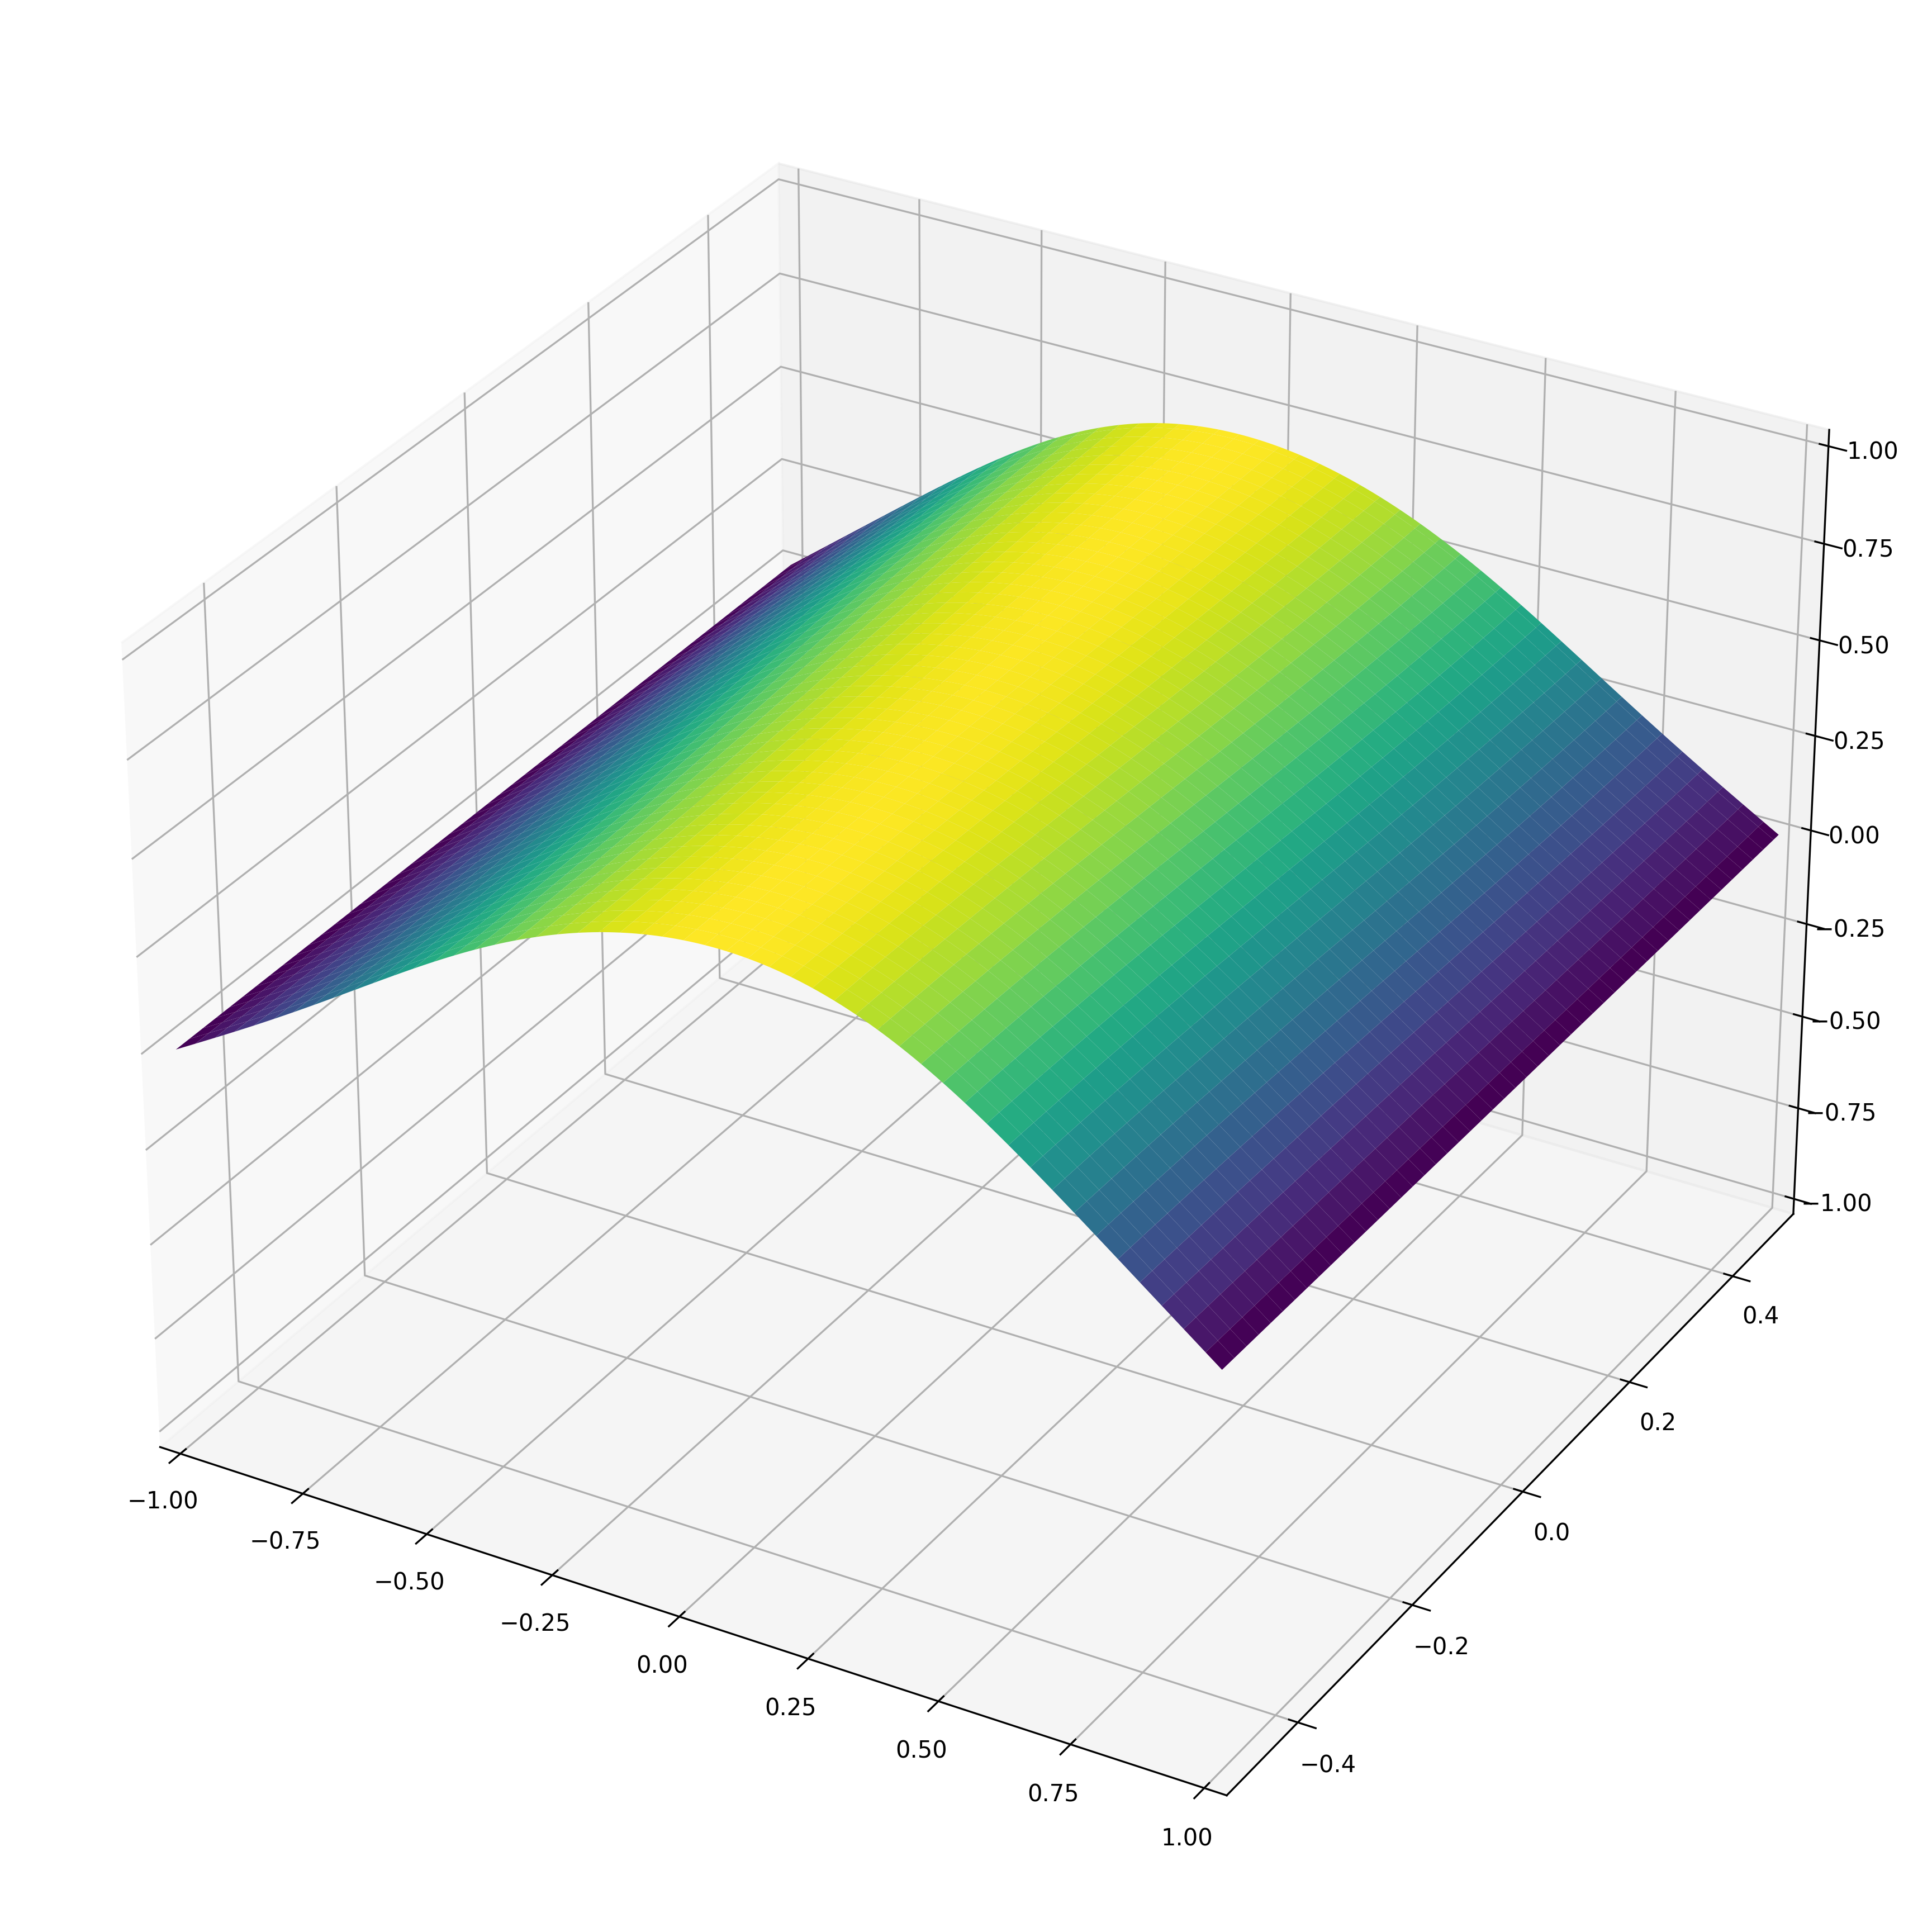

In [346]:
# создание анимации: приближенное решение 
solverVec = SolverVec(a, b, h, phi, psi)
solverVec.first_step(dt)

duration = 40
fps = 30
iterations = fps * duration + 1
drop = 4
print(iterations)
print(len(np.arange(0, duration, 1.0/fps)))

time_cube_solver = np.zeros((iterations, solverVec.x.shape[0], solverVec.x.shape[1])) # len(solverVec.y), len(solverVec.x)
start = time.time()
for i in tqdm.trange(iterations):
	curU = solverVec.advance(dt)
	if i % drop == 0: time_cube_solver[i//drop] = curU
print('Среднее время итерации:', (time.time() - start) / iterations)

# figsize - 1 == 72px -> 20 - 1440p / 15 - 1080p

# fig = plt.figure(figsize=(15, 15))
fig = plt.figure(figsize=(15, 15))
ax = fig.add_subplot(projection='3d')

# display.clear_output()
idx = 0

# каждая отрисовка ~ <=40мс
def make_frame(t):
	global idx
	ax.clear()
	ax.set_xlim(-a/2, a/2)
	ax.set_ylim(-b/2, b/2)
	ax.set_zlim(-1, 1)
	ax.plot_surface(solverVec.x, solverVec.y, time_cube_solver[idx], cmap='viridis', edgecolor='none')
	npimg = mplfig_to_npimage(fig)
	idx += 1
	return npimg


animation = VideoClip(make_frame, duration=duration/drop)
animation.write_videofile(f'vid_final{1}.mp4', fps=fps, codec='mpeg4', audio=False, bitrate='6M', threads = 12, preset='ultrafast')

(100, 200)
(100, 200)
1201
1200


100%|██████████| 1201/1201 [00:00<00:00, 3908.49it/s]


Среднее время итерации: 0.00025752065183717344


100%|██████████| 1201/1201 [00:00<00:00, 2209.78it/s]


Среднее время итерации: 0.00045420168639221953
Moviepy - Building video compare_final2.mp4.
Moviepy - Writing video compare_final2.mp4



Moviepy - Done !
Moviepy - video ready compare_final2.mp4


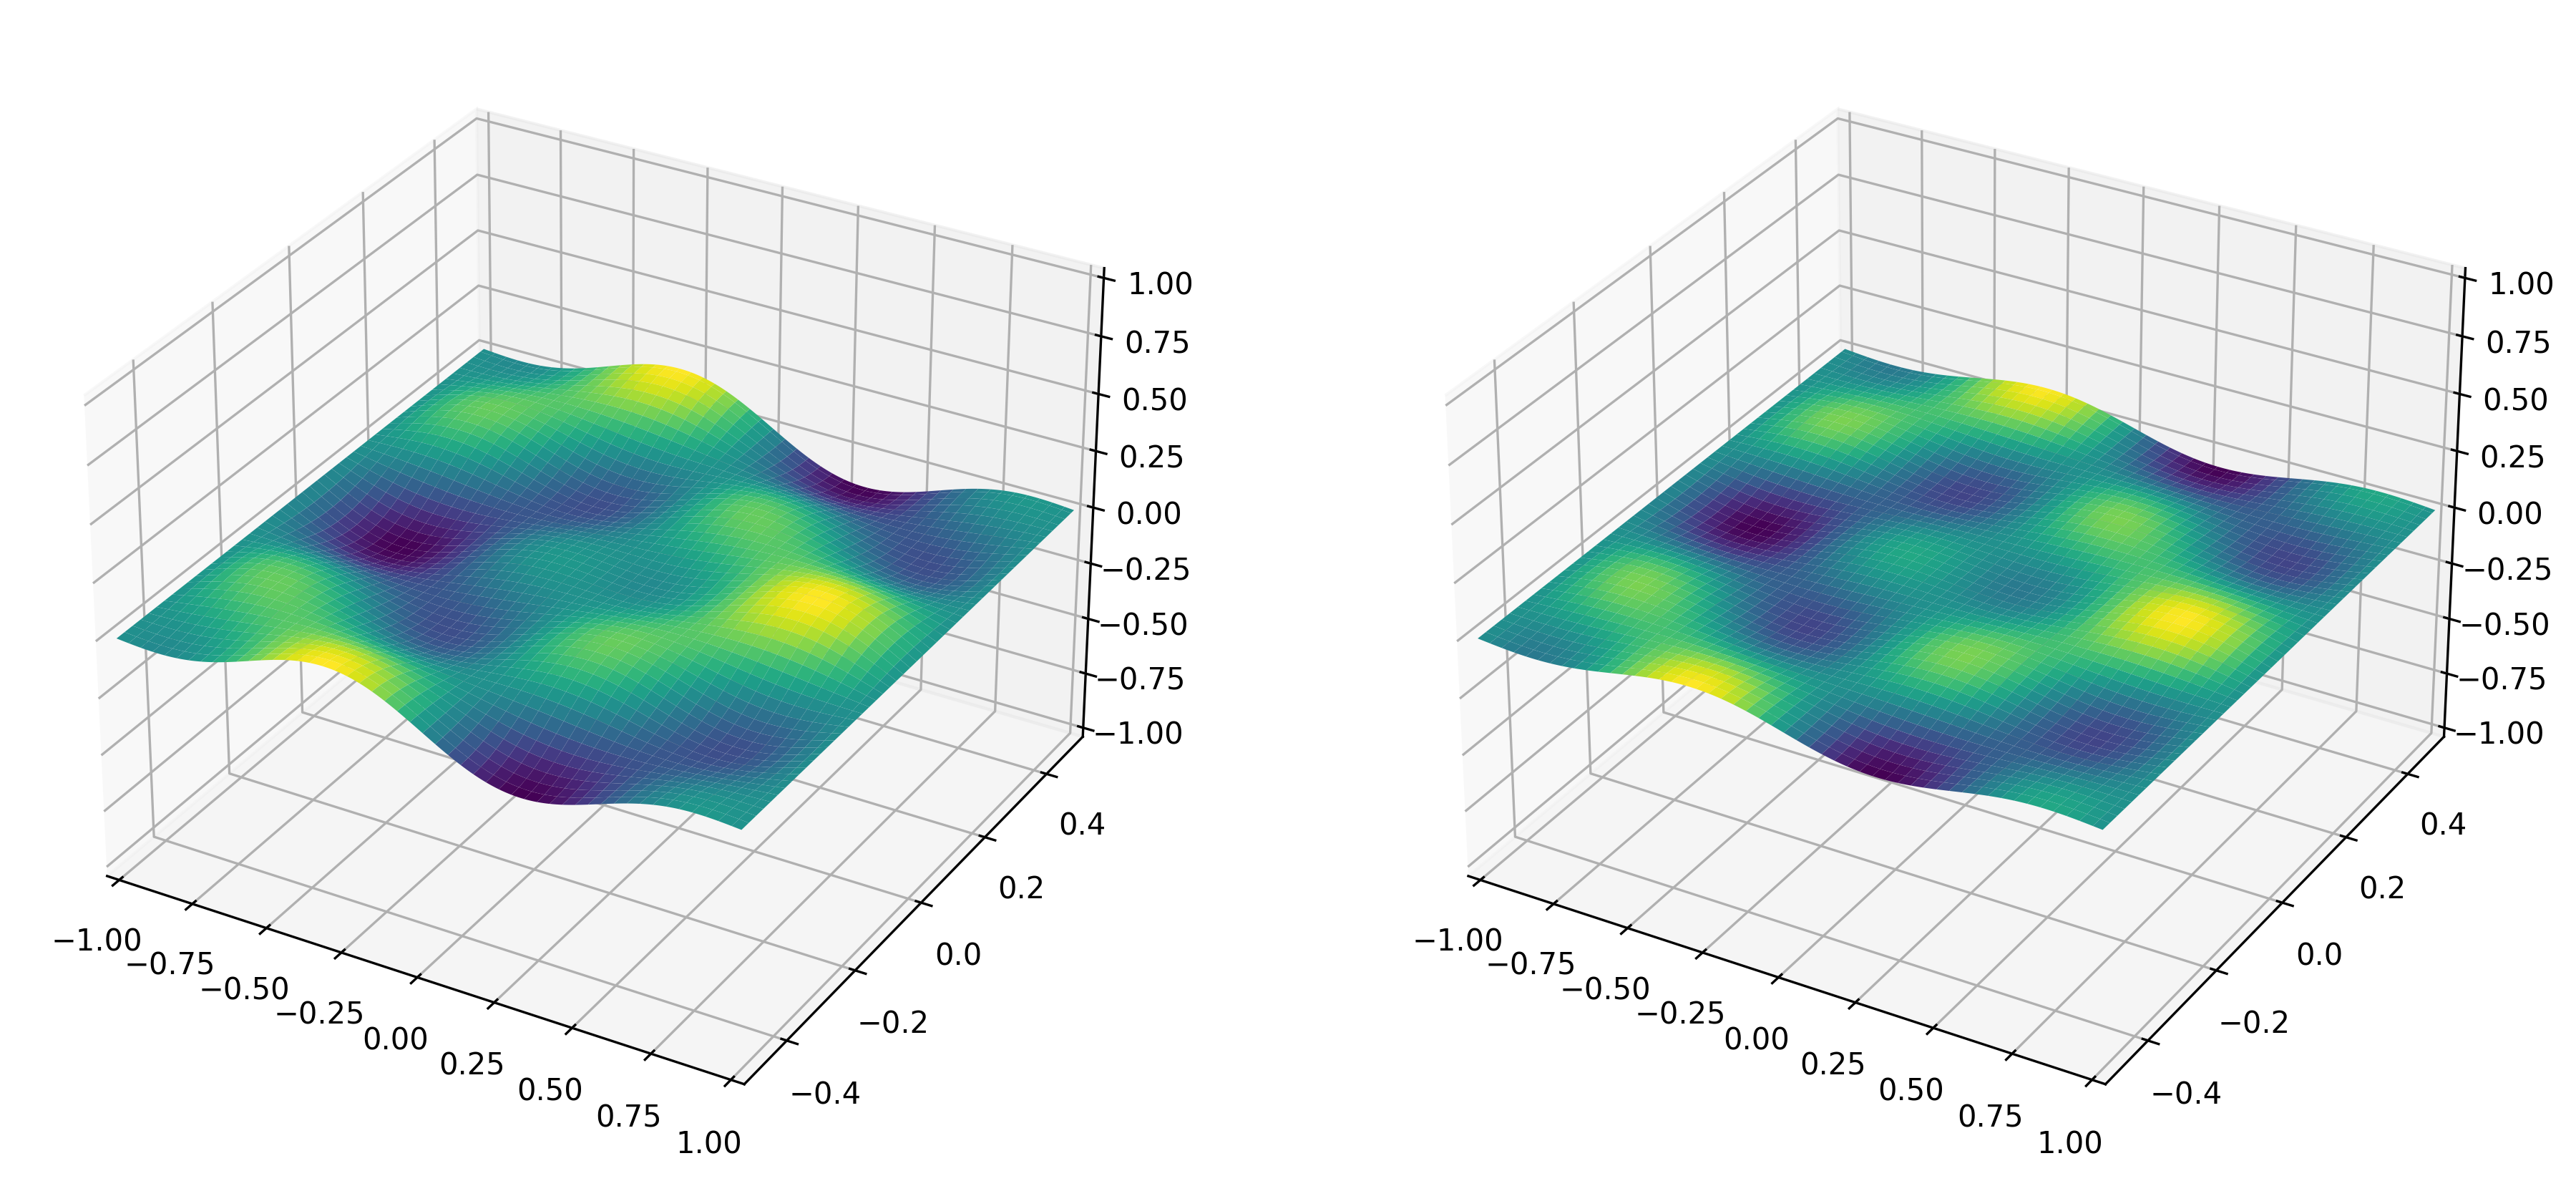

In [344]:
# создание анимации: точное и приближенное решение
solverVec = SolverVec(a, b, h, testphi, testpsi)
solverVec.first_step(dt)

duration = 40
fps = 30
iterations = fps * duration + 1
drop = 4
print(iterations)
print(len(np.arange(0, duration, 1.0/fps)))

time_cube_solver = np.zeros((iterations, solverVec.x.shape[0], solverVec.x.shape[1])) # len(solverVec.y), len(solverVec.x)
start = time.time()
for i in tqdm.trange(iterations):
	curU = solverVec.advance(dt)
	if i % drop == 0: time_cube_solver[i//drop] = curU
print('Среднее время итерации:', (time.time() - start) / iterations)

# figsize - 1 == 72px -> 20 - 1440p / 15 - 1080p
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15, 7), subplot_kw={'projection': '3d'})

idx = 0
# функция отрисовки графика (~ <=40мс)
def make_frame(t):
	global idx
	ax.clear()
	ax.set_xlim(-a/2, a/2)
	ax.set_ylim(-b/2, b/2)
	ax.set_zlim(-1, 1)
	ax.plot_surface(x1, y1, time_cube[idx], cmap='viridis', edgecolor='none')
	ax2.clear()
	ax2.set_xlim(-a/2, a/2)
	ax2.set_ylim(-b/2, b/2)
	ax2.set_zlim(-1, 1)
	ax2.plot_surface(x1, y1, time_cube_solver[idx], cmap='viridis', edgecolor='none')
	npimg = mplfig_to_npimage(fig)
	idx += 1
	return npimg


animation = VideoClip(make_frame, duration=duration/drop)
animation.write_videofile(f'compare_final{2}.mp4', fps=fps, codec='mpeg4', audio=False, bitrate='6M', threads = 12, preset='ultrafast')

1201
1200


100%|██████████| 1201/1201 [00:00<00:00, 35291.44it/s]


Среднее время итерации: 3.0836594491874444e-05


100%|██████████| 1201/1201 [00:00<00:00, 8107.49it/s]


Среднее время итерации: 0.0001250091540029305
Moviepy - Building video compare4.mp4.
Moviepy - Writing video compare4.mp4



Moviepy - Done !
Moviepy - video ready compare4.mp4


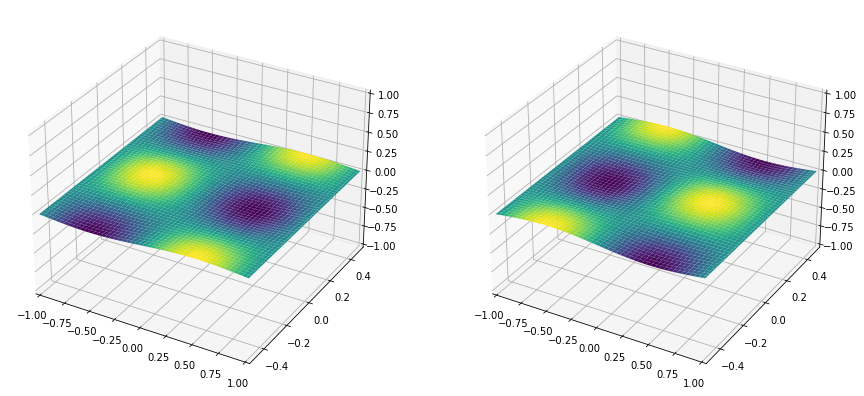

In [11]:
# прогон и анимация тестового примера (точное решения)
duration = 40
fps = 30
iterations = fps * duration + 1
drop = 4
print(iterations)
print(len(np.arange(0, duration, 1.0/fps)))

# errList = []


# err = np.max(np.abs(u - uTrue))
# errList.append(err)

# axs.plot([i for i in range(observations)], [errList[i] for i in range(observations)], label='Error')
# axs.set_xlabel('Observation')
# axs.set_ylabel('Error')

time_cube = np.zeros((iterations, solverVec.y.shape[0], solverVec.x.shape[0]))
x1, y1 = np.meshgrid(solverVec.x, solverVec.y)
start = time.time()
t = dt*2
for i in tqdm.trange(iterations):
	if i % drop == 0: time_cube[i//drop] = testU(x1, y1, t, a, b)
	t += dt
print('Среднее время итерации:', (time.time() - start) / iterations)


time_cube_solver = np.zeros((iterations, solverVec.y.shape[0], solverVec.x.shape[0])) # len(solverVec.y), len(solverVec.x)
start = time.time()
for i in tqdm.trange(iterations):
	curU = solverVec.advance(dt)
	if i % drop == 0: time_cube_solver[i//drop] = curU
print('Среднее время итерации:', (time.time() - start) / iterations)

# figsize - 1 == 72px -> 20 - 1440p / 15 - 1080p

# fig = plt.figure(figsize=(15, 15))
fig, (ax, ax2) = plt.subplots(ncols=2, figsize=(15, 7), subplot_kw={'projection': '3d'})
# ax = fig.add_subplot(projection='3d')
# ax2 = fig.add_subplot(projection='3d')
# display.clear_output()
idx = 0

# каждая отрисовка ~ <=40мс
def make_frame(t):
	global idx
	ax.clear()
	ax.set_xlim(-a/2, a/2)
	ax.set_ylim(-b/2, b/2)
	ax.set_zlim(-1, 1)
	ax.plot_surface(x1, y1, time_cube[idx], cmap='viridis', edgecolor='none')
	ax2.clear()
	ax2.set_xlim(-a/2, a/2)
	ax2.set_ylim(-b/2, b/2)
	ax2.set_zlim(-1, 1)
	ax2.plot_surface(x1, y1, time_cube[idx] - time_cube_solver[idx], cmap='viridis', edgecolor='none')
	npimg = mplfig_to_npimage(fig)
	idx += 1
	return npimg



animation = VideoClip(make_frame, duration=duration/drop)
animation.write_videofile(f'compare{5}.mp4', fps=fps, codec='mpeg4', audio=False, bitrate='6M', threads = 12, preset='ultrafast')